# Critical Temperature of Superconductors

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.style.use("seaborn-v0_8")

DATA_FOLDER = "data/"

---
---
## Data Visualization

Are provided two different datasets:
- *'Properties'* includes the different chemical/physical properties of the materials
- *'Formula'* includes the chemical formula of each material, one column for each chemical element

In [4]:
print("Shapes of Properties df: ", pd.read_csv(DATA_FOLDER + "train.csv").shape)
print("Shapes of Formula df: ", pd.read_csv(DATA_FOLDER + "formula_train.csv").shape)

Shapes of Properties df:  (17010, 82)
Shapes of Formula df:  (17010, 88)


In [5]:
df = pd.concat(
    [
        pd.read_csv(DATA_FOLDER + "formula_train.csv").drop(columns=["critical_temp"]),
        pd.read_csv(DATA_FOLDER + "train.csv"),
    ],
    axis=1,
)
print("Shapes of Properties+Formula df: ", df.shape)

Shapes of Properties+Formula df:  (17010, 169) True


In [6]:
def reduce_memory_usage(df):
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != "object":
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype("category")

    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df


# df = reduce_memory_usage(df)

---
- Each row describes a superconductor
- The Properties features are 8 basic chemical properties (absolute value, average, weighted average, and so on):
    - atomic mass
    - ionization energy
    - atomic radius
    - density
    - electron affinity energy
    - specific heat of melting
    - thermal conductivity
    - valence
- The target is the critical temperature of the superconductor (last column)
- All features are numerical, exept the formula written in plain text. It is removed
- No null values
- No strictly-duplicated rows are present. Some lines has the same values exept the formula. Since the documentation says that each row is a single superconductor, no duplicated rows are removed
- Some highly-correlated features will be removed, varying a given threshold
- The features values belong into different ranges, thus a scaling will be needed, and present different value distributions

In [7]:
display(df.head(5))
df.info()
display(df.describe())

,H,He,Li,Be,B,C,N,O,F,Ne,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Columns: 169 entries, H to critical_temp
dtypes: float64(156), int64(12), object(1)
memory usage: 21.9+ MB


None

,H,He,Li,Be,B,C,N,O,F,Ne,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,17010.000000,17010.0,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.0,...,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000
mean,0.018447,0.0,0.011884,0.035189,0.141945,0.376868,0.012462,3.010023,0.015318,0.0,...,3.151430,3.055206,3.054358,1.295344,1.052631,2.042034,1.482988,0.839731,0.673590,34.502993
std,0.287419,0.0,0.125699,0.861767,1.107689,4.357716,0.123290,3.796711,0.136147,0.0,...,1.192035,1.045869,1.175579,0.393231,0.380725,1.244305,0.980906,0.485728,0.454975,34.334793
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,2.117647,2.245649,2.091629,1.060857,0.779166,1.000000,0.920000,0.451754,0.307467,5.330000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,2.605455,2.615321,2.429201,1.368922,1.168512,2.000000,1.062857,0.800000,0.500000,20.000000
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.800000,0.000000,0.0,...,4.019566,3.722419,3.914868,1.589027,1.331531,3.000000,1.912000,1.200000,1.020735,63.000000
max,14.000000,0.0,2.600000,40.000000,105.000000,120.000000,5.000000,66.000000,4.000000,0.0,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


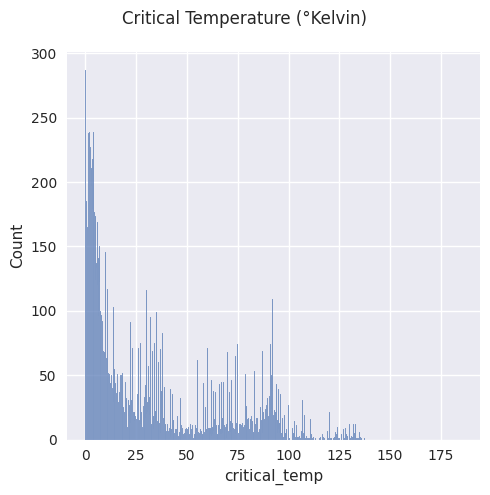

In [8]:
# Plot Target feature
sns.displot(df["critical_temp"], bins=700).figure.suptitle("Critical Temperature (°Kelvin)")
plt.tight_layout()
plt.show()

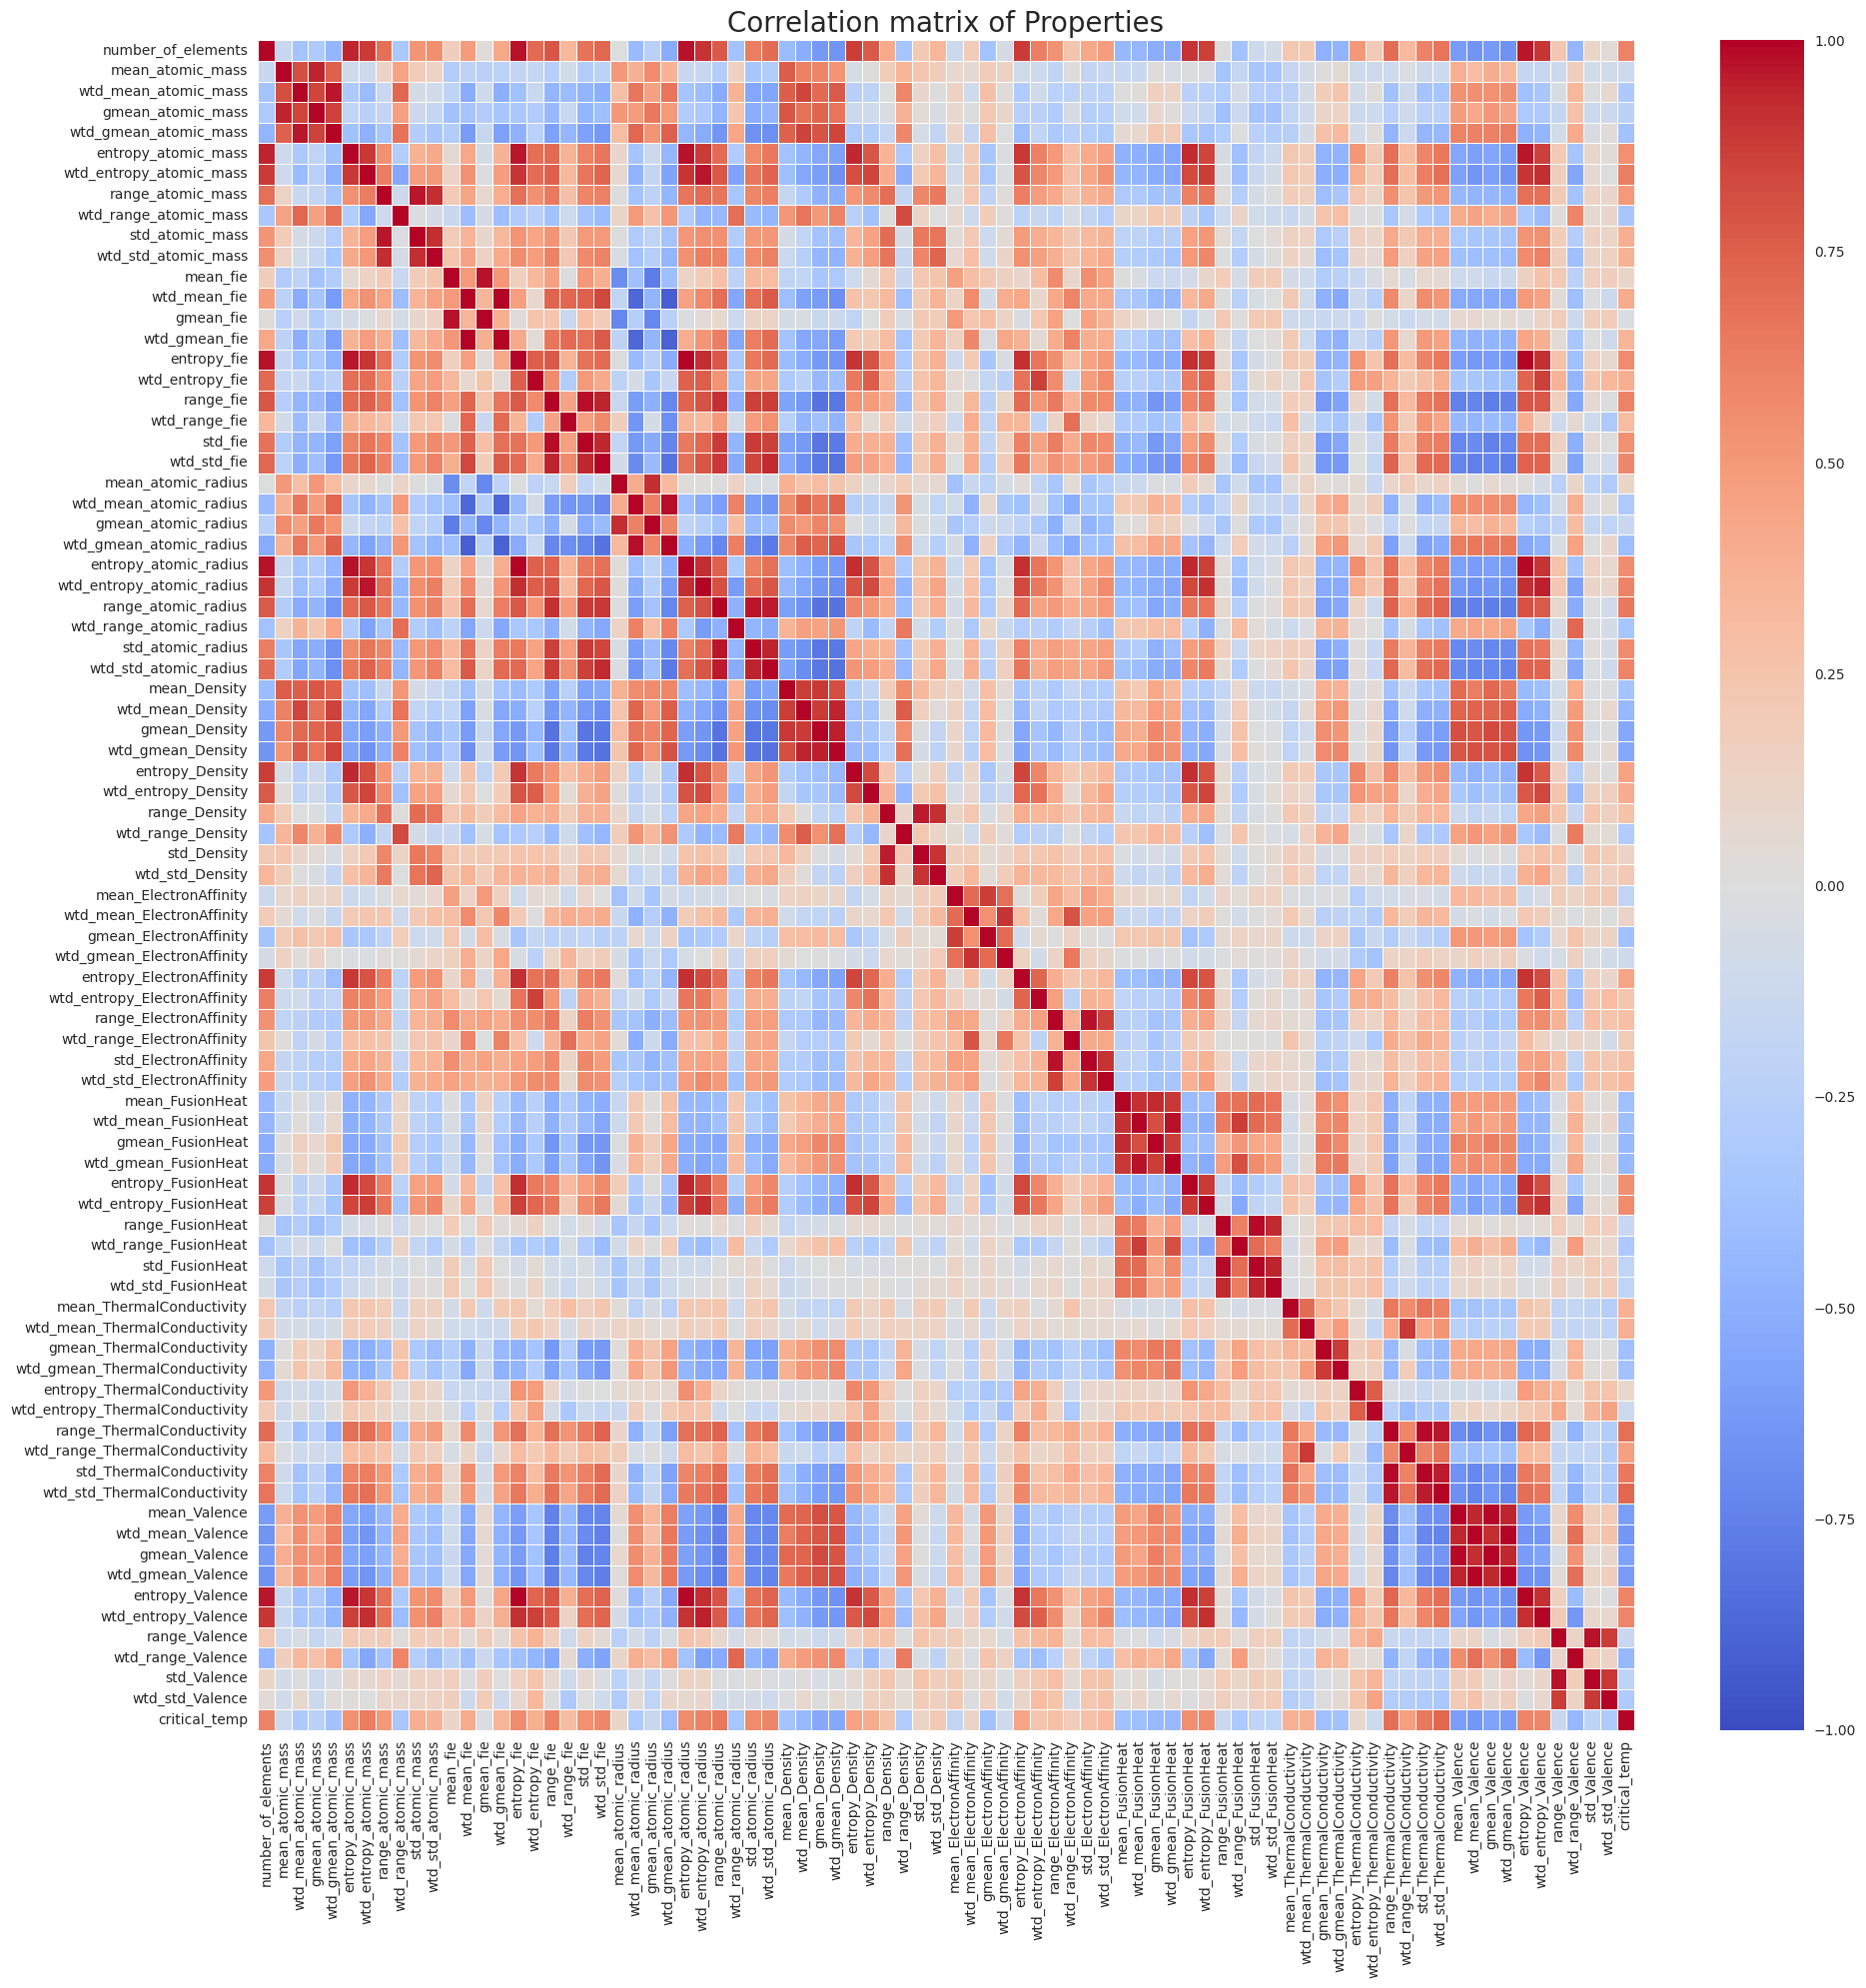

In [9]:
# Plot correlation matrix of only the Properties features
plt.figure(figsize=(20, 20))
sns.heatmap(
    df.drop(columns="material").iloc[:, 86:].corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation matrix of Properties", fontsize=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

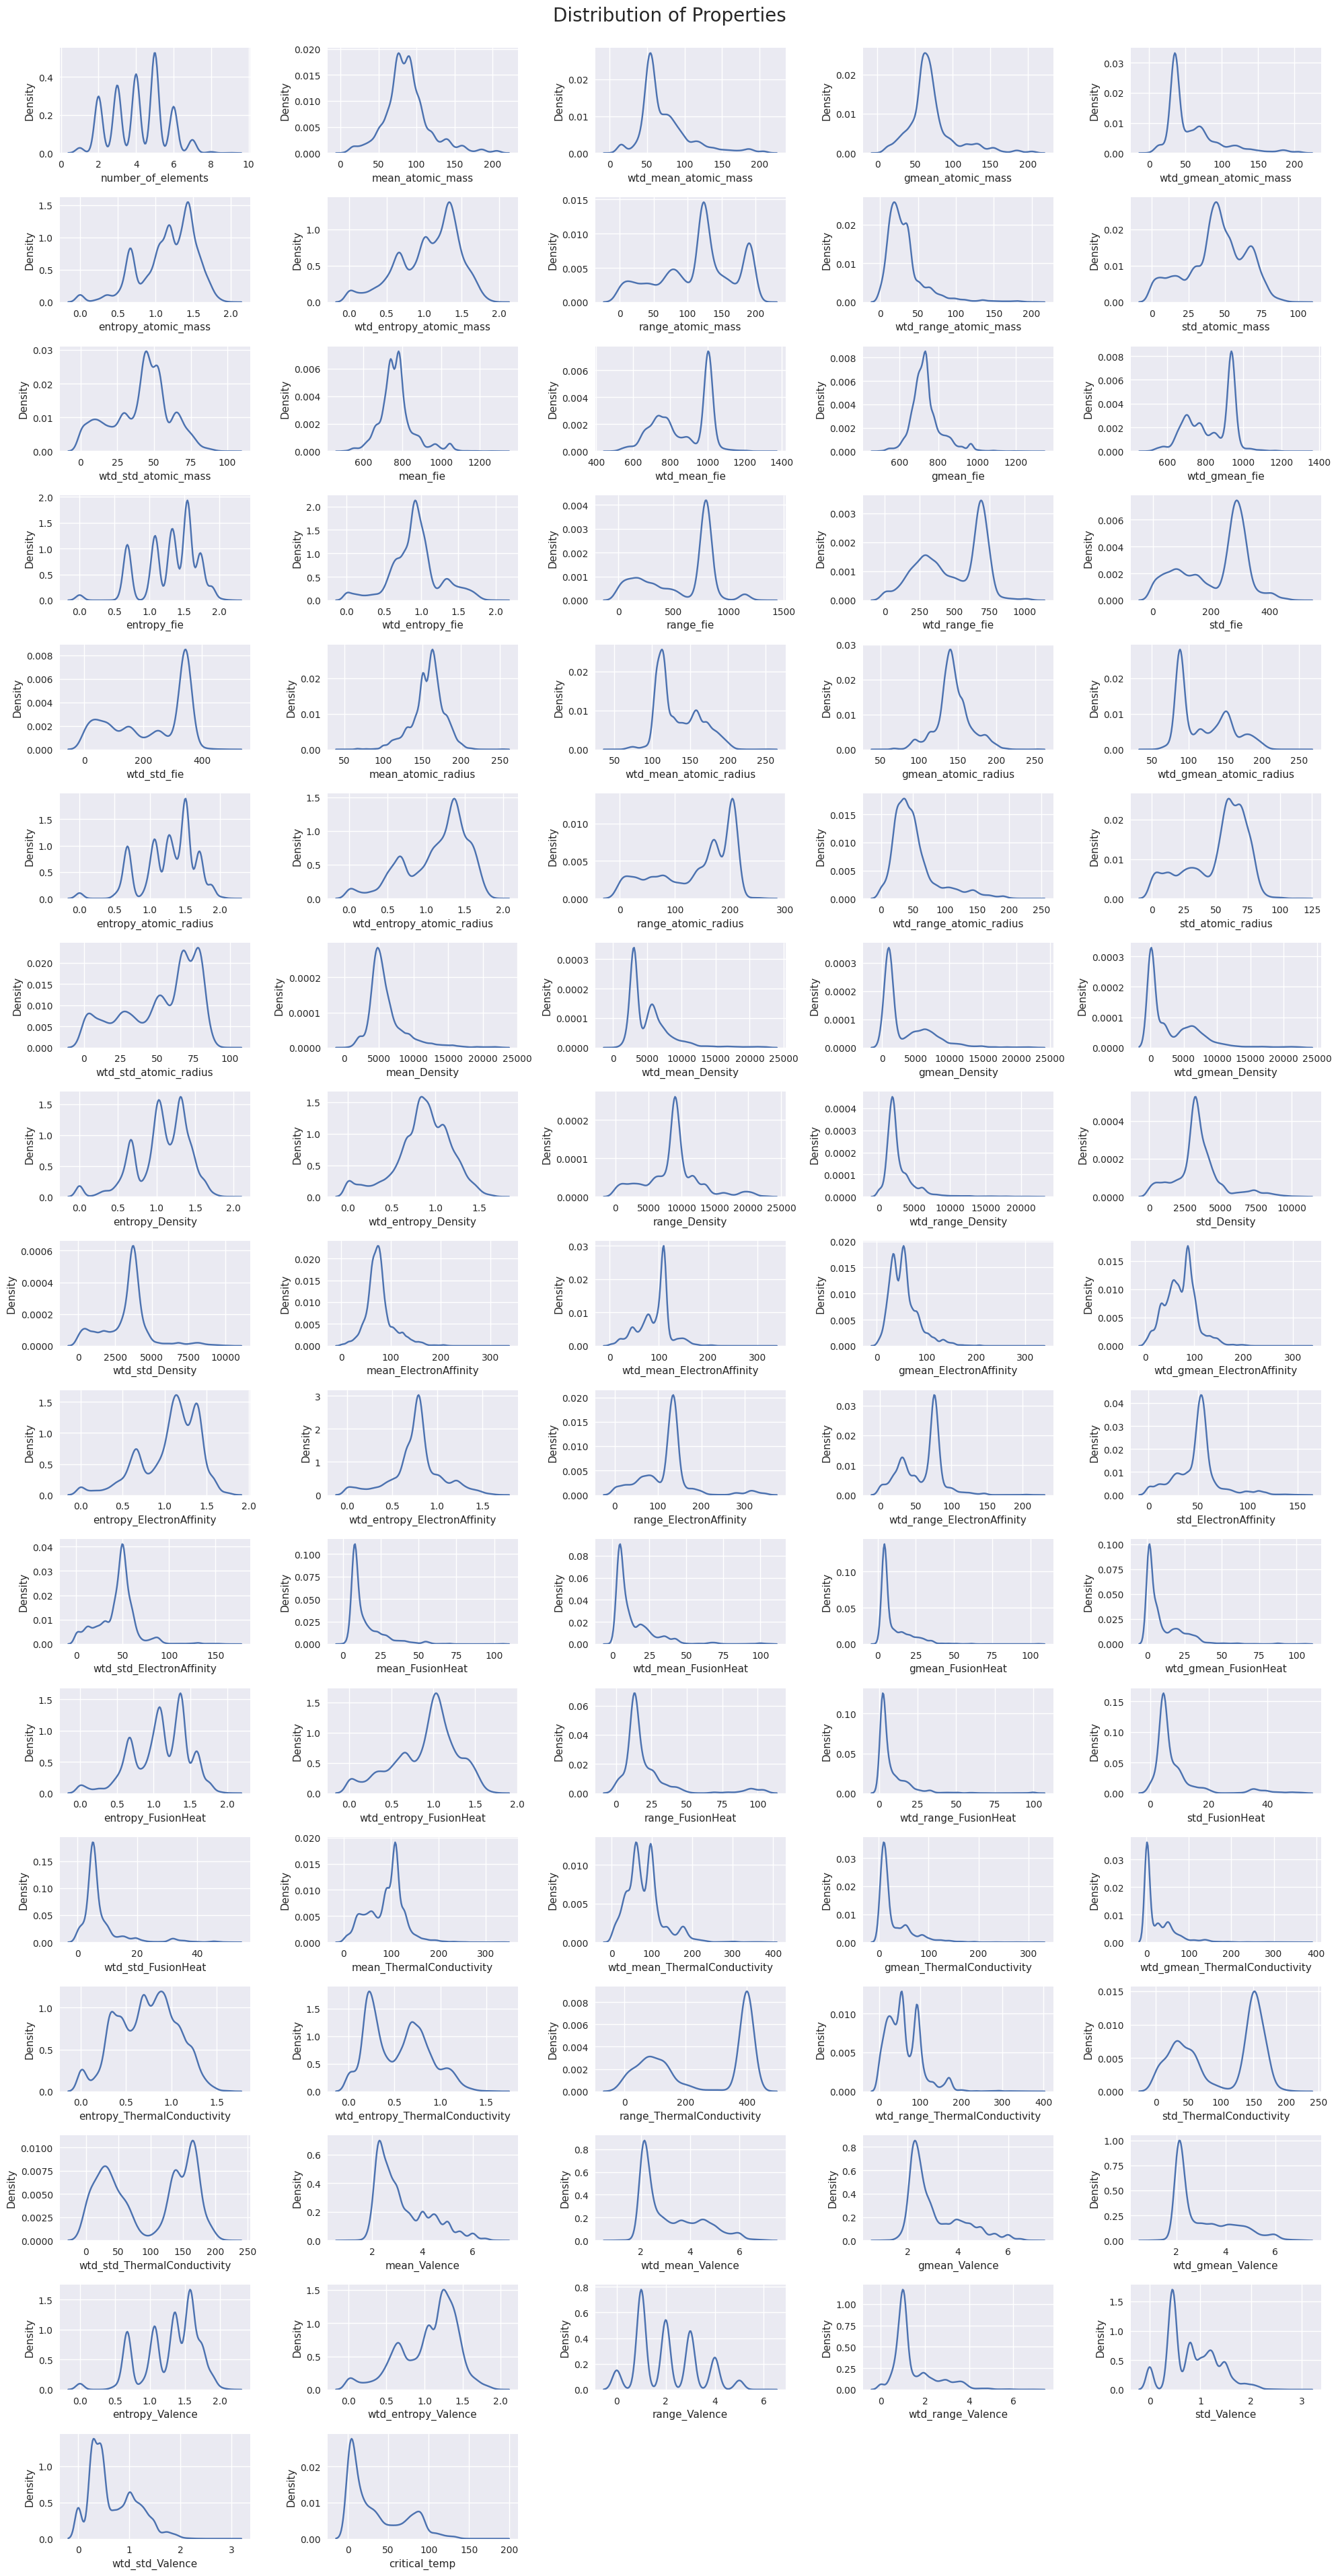

In [11]:
# Distribution of Properties
pos = 1
fig = plt.figure(figsize=(20, 40))
fig.suptitle("Distribution of Properties", y=1, fontsize=20)

for col in df.drop(columns="material").columns[86:]:
    plt.subplot(18, 5, pos)
    plt.xlabel(col)
    sns.kdeplot(df[col])
    pos = pos + 1

plt.tight_layout()
plt.show()